In [ ]:
import sys
print (sys.executable)

# 1️⃣ Data Inspection
Before any cleaning, we inspect the raw datasets to understand their structure and identify potential issues. This includes:
- **Dataset Overview:** Summary statistics, data types, and a preview of the data.
- **Missing Values & Duplicates:** Checking for data quality issues.


### Import Libraries & Helper Functions
We import the necessary libraries and define a helper function to standardize column names (converting them to lowercase and replacing spaces with underscores). This ensures consistency across our datasets.



In [2]:
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import RobustScaler

# Standardize column names
def standardize_column_names(df):
    df.columns = df.columns.str.lower().str.strip().str.replace(" ", "_")
    return df


### Load Dataset & Standardize Column Names
- Load the development (`dev_df`) and validation (`val_df`) datasets.
- Standardize column names for consistency (lowercase, underscores instead of spaces).


In [3]:
# Load datasets
dev_df = pd.read_csv("../data/assignment1_dev_set.csv")
val_df = pd.read_csv("../data/assignment1_val_set.csv")

# Standardize column names
dev_df = standardize_column_names(dev_df)
val_df = standardize_column_names(val_df)

# Data Inspection
print("\n✅ Column names standardized!")
print("\n🔍 First few column names (Development Set):", list(dev_df.columns)[:10])



✅ Column names standardized!

🔍 First few column names (Development Set): ['unnamed:_0', 'project_id', 'experiment_type', 'sex', 'host_age', 'bmi', 'disease_mesh_id', 'acholeplasma_axanthum', 'acidaminococcus_fermentans', 'acidaminococcus_intestini']


### Dataset Overview & Quality Checks
We review:
- Data types using `.info()`
- Missing values to confirm there are none
- Duplicate entries to ensure data uniqueness
- Summary statistics to understand the spread of the data


In [4]:
# Dataset Overview
print("\n🔍 Dataset Overview (Development Set):")
print(dev_df.info())
print("\n🔍 Dataset Overview (Validation Set):")
print(val_df.info())

# Check for missing values
print("\n🔎 Missing Values (Development Set):")
print(dev_df.isnull().sum()[dev_df.isnull().sum() > 0])
print("\n🔎 Missing Values (Validation Set):")
print(val_df.isnull().sum()[val_df.isnull().sum() > 0])

# Check for duplicates
print("\n🔎 Duplicate Rows in Development Set:", dev_df.duplicated().sum())
print("🔎 Duplicate Rows in Validation Set:", val_df.duplicated().sum())

# Display summary statistics
print("\n📊 Summary Statistics (Development Set):")
print(dev_df.describe())
print("\n📊 Summary Statistics (Validation Set):")
print(val_df.describe())



🔍 Dataset Overview (Development Set):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 489 entries, 0 to 488
Columns: 141 entries, unnamed:_0 to ruminococcus_gnavus
dtypes: float64(136), int64(1), object(4)
memory usage: 538.8+ KB
None

🔍 Dataset Overview (Validation Set):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211 entries, 0 to 210
Columns: 141 entries, unnamed:_0 to ruminococcus_gnavus
dtypes: float64(136), int64(1), object(4)
memory usage: 232.6+ KB
None

🔎 Missing Values (Development Set):
Series([], dtype: int64)

🔎 Missing Values (Validation Set):
Series([], dtype: int64)

🔎 Duplicate Rows in Development Set: 0
🔎 Duplicate Rows in Validation Set: 0

📊 Summary Statistics (Development Set):
       unnamed:_0    host_age        bmi  acholeplasma_axanthum  \
count  489.000000  489.000000  489.00000             489.000000   
mean   244.000000   46.703497   24.93955               0.016818   
std    141.306405   15.728231    4.20771               0.145035   
min      0.0000

# 2️⃣ Data Cleaning
Based on our inspection, we now clean the dataset to prepare it for analysis and modeling. This includes:
- **Dropping Unnecessary Columns:** Removing non-informative columns (e.g., index, project_id, experiment_type, disease_mesh_id).
- **Categorical Encoding:** Converting the `sex` column into a one-hot encoded variable (resulting in `sex_male`), and ensuring `host_age` is numeric.
- **Defining Microbial Features:** Creating a list of microbial (bacterial) features by excluding non-relevant columns (`bmi`, `host_age`, `sex_male`).
- **Outlier Detection:** Identifying features with extreme values using Z-scores.
The insights from this section will inform our cleaning and transformation strategies.

This step is critical to ensure that our subsequent modeling is based only on relevant bacterial data.

### Dropping Unnecessary Columns
We remove columns that do not contribute to our analysis (e.g., indices and metadata). This simplifies our dataset and reduces noise in subsequent steps.



In [5]:
# Drop Unnecessary Columns
columns_to_drop = ["unnamed:_0", "project_id", "experiment_type", "disease_mesh_id"]
dev_df_clean = dev_df.drop(columns=columns_to_drop)
val_df_clean = val_df.drop(columns=columns_to_drop)
print("\n✅ Dropped unnecessary columns:", columns_to_drop)



✅ Dropped unnecessary columns: ['unnamed:_0', 'project_id', 'experiment_type', 'disease_mesh_id']


### Categorical Encoding & Feature Selection
- **One-hot encode `sex`** to convert it into a binary feature (`sex_male`).
- **Standardize column names** again to ensure that new columns follow the same format.
- **Convert `host_age` to numeric.**
- **Define microbial features** by excluding `bmi`, `host_age`, and `sex_male`. These microbial features will be used for modeling.


In [6]:
# One-hot encode 'sex' (now standardized to lowercase)
dev_df_clean = pd.get_dummies(dev_df_clean, columns=["sex"], drop_first=True)
val_df_clean = pd.get_dummies(val_df_clean, columns=["sex"], drop_first=True)

# Standardize column names again to ensure consistency
dev_df_clean = standardize_column_names(dev_df_clean)
val_df_clean = standardize_column_names(val_df_clean)

# Ensure 'host_age' is numerical
dev_df_clean["host_age"] = pd.to_numeric(dev_df_clean["host_age"], errors='coerce')
val_df_clean["host_age"] = pd.to_numeric(val_df_clean["host_age"], errors='coerce')

print("\n✅ Categorical encoding complete! 'sex' converted to 'sex_male'")

# Define microbial features
non_microbial_features = ["bmi", "host_age", "sex_male"]
microbial_features = [col for col in dev_df_clean.columns if col not in non_microbial_features]

print("\n✅ Microbial feature selection complete! Features identified:", len(microbial_features))



✅ Categorical encoding complete! 'sex' converted to 'sex_male'

✅ Microbial feature selection complete! Features identified: 134


### Outlier Detection (on Cleaned Microbial Features) 
We compute Z-scores on the cleaned dataset (dev_df_clean) for the microbial features only (excluding `bmi`, `host_age`, and `sex_male`) to detect outliers (|Z| > 3). These findings help us determine if extreme values require special handling in later steps.
 

In [ ]:
# Compute Z-scores for each microbial feature in dev_df_clean
z_scores = np.abs(stats.zscore(dev_df_clean[microbial_features]))

# Count the number of outliers (absolute Z > 3) per feature
outlier_counts = (z_scores > 3).sum(axis=0)

# Check the Z-score statistics
print(z_scores.describe())

# Display features with at least one outlier
print("\n📌 Number of Outliers per Microbial Feature (Development Set):")
print(outlier_counts[outlier_counts > 0].sort_values(ascending=False))


       acholeplasma_axanthum  acidaminococcus_fermentans  \
count             489.000000                  489.000000   
mean                0.209967                    0.278490   
std                 0.978710                    0.961423   
min                 0.009061                    0.012169   
25%                 0.116074                    0.151651   
50%                 0.116074                    0.151651   
75%                 0.116074                    0.151651   
max                19.632522                   13.120837   

       acidaminococcus_intestini  actinomyces_lingnae  \
count                 489.000000           489.000000   
mean                    0.541591             0.254056   
std                     0.841503             0.968180   
min                     0.000440             0.000724   
25%                     0.356832             0.154353   
50%                     0.366867             0.154353   
75%                     0.366867             0.154353   
max

## 3️⃣ Data Visualizations
Now that the dataset is cleaned, we explore the data visually to understand the distributions and relationships between variables. This exploration will inform our preprocessing choices for the regression task.


### Histogram of BMI (Log-Transformed)
**Purpose:**  
Visualize the distribution of BMI values after applying a log transformation.  
**Insight:**  
- The log transformation helps reveal the underlying distribution by reducing the effect of extreme high values.  
- This informs whether additional transformation or scaling is needed for our target variable.


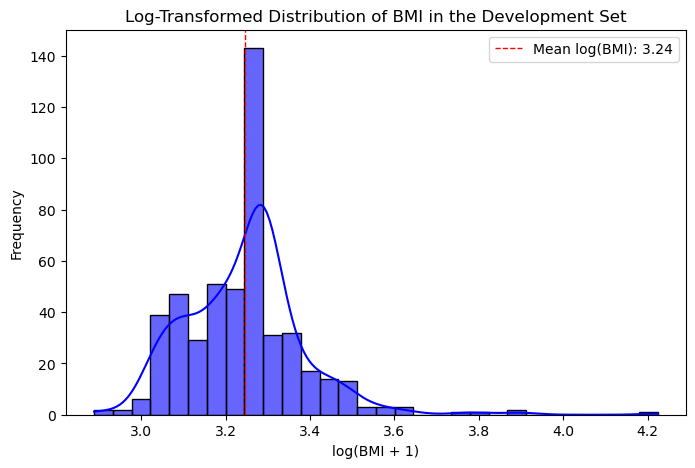

In [9]:
# Ensure dataset is correctly referenced
df = dev_df_clean.copy()

# Compute log-transformed BMI
df["log_bmi"] = np.log1p(df["bmi"])

# Create the plot
fig, ax = plt.subplots(figsize=(8, 5))
sns.histplot(df["log_bmi"], bins=30, kde=True, color="blue", alpha=0.6, ax=ax)

# Overlay mean BMI
mean_bmi = df["log_bmi"].mean()
ax.axvline(mean_bmi, color='red', linestyle='dashed', linewidth=1, label=f"Mean log(BMI): {mean_bmi:.2f}")

# Formatting
ax.set_title("Log-Transformed Distribution of BMI in the Development Set")
ax.set_xlabel("log(BMI + 1)")
ax.set_ylabel("Frequency")
ax.legend()

plt.show()


### Violin Plot of Top 10 Most Variable Microbial Features (Log-Transformed)
**Purpose:**  
Examine the distribution of microbial abundances for the most variable features.  
**Insight:**  
- Log transformation makes skewed distributions more interpretable.  
- This visualization helps us decide if certain features might require special handling (e.g., further transformation or exclusion) before modeling.


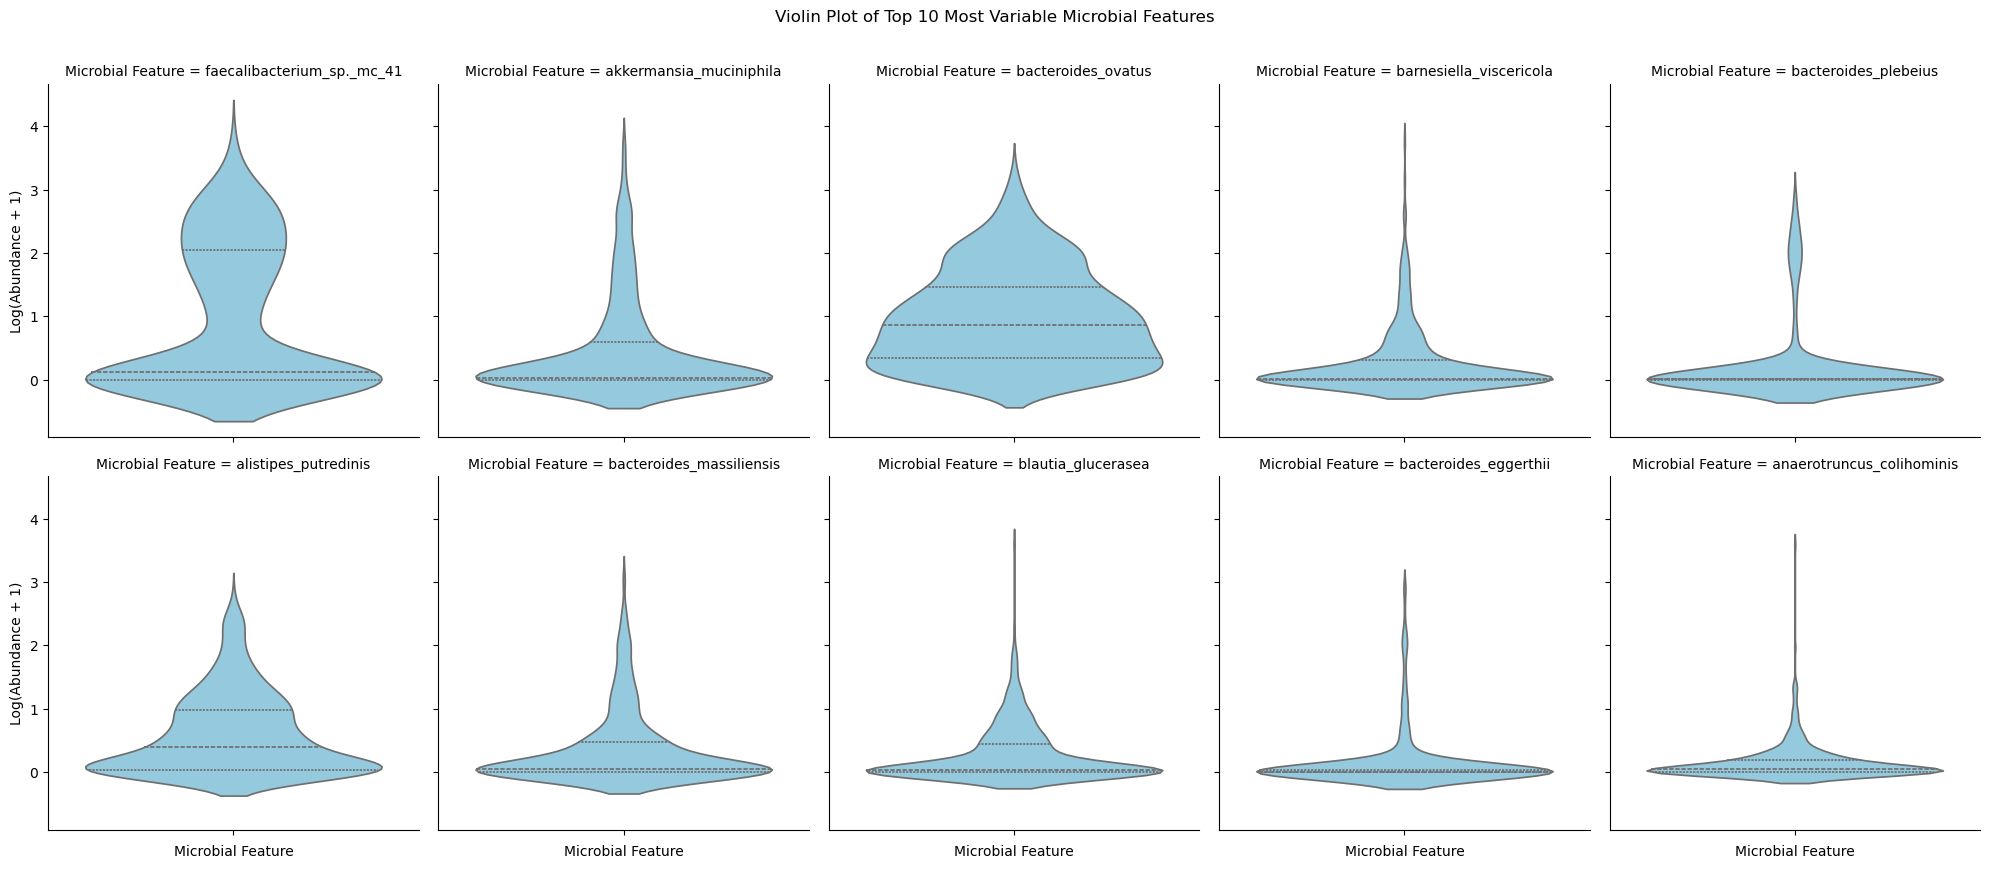

In [10]:
# Select top 10 microbial features based on variance
var_microbial_features = df[microbial_features].var().nlargest(10).index

# Melt the dataframe for seaborn's violin plot
df_melted_violin = df.melt(value_vars=var_microbial_features, var_name="Microbial Feature", value_name="Abundance")

# Log transform the abundance values for better visualization
df_melted_violin["Log Abundance"] = np.log1p(df_melted_violin["Abundance"])

# Create FacetGrid to plot individual violins separately
g_violin = sns.FacetGrid(df_melted_violin, col="Microbial Feature", col_wrap=5, sharex=False, sharey=True, height=4)
g_violin.map_dataframe(sns.violinplot, y="Log Abundance", color="skyblue", inner="quartile")

# Formatting
g_violin.set_axis_labels("Microbial Feature", "Log(Abundance + 1)")
plt.suptitle("Violin Plot of Top 10 Most Variable Microbial Features", y=1.05)

plt.show()


### Correlation Heatmap of Top 10 Microbial Features Correlated with BMI
**Purpose:**  
Identify the bacterial species that have the strongest linear relationships with BMI.  
**Insight:**  
- Features with higher absolute correlations with BMI are likely to be good predictors in our regression model.
- Weak correlations might indicate features that add noise rather than useful information.


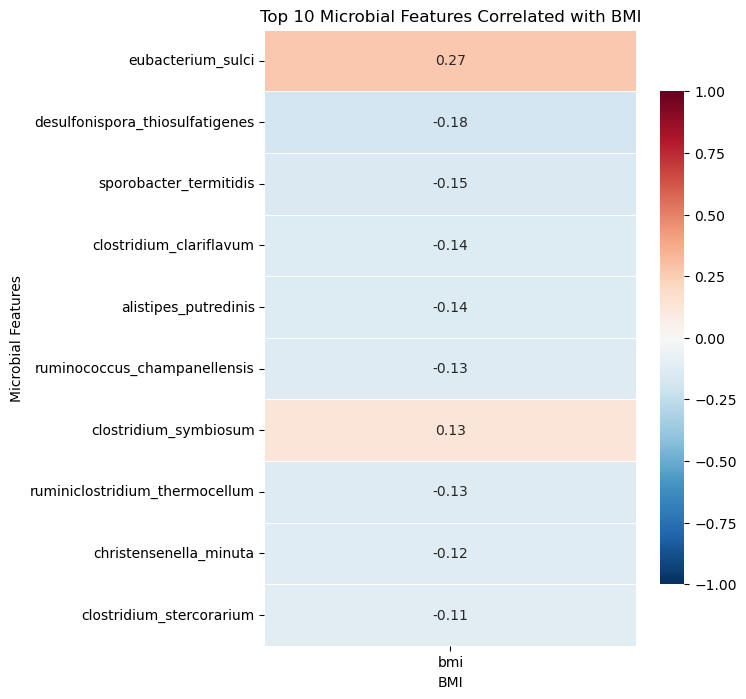

In [11]:
# Compute correlation matrix
corr_matrix = df[microbial_features + ["bmi"]].corr()

# Select features with at least moderate correlation (absolute value > 0.1)
filtered_corrs = corr_matrix["bmi"].abs().sort_values(ascending=False)[1:]  # Exclude BMI itself
filtered_corrs = filtered_corrs[filtered_corrs > 0.1]  # Apply threshold

# Select the top 10 most correlated features
corr_microbial_features = filtered_corrs[:10].index
top_corrs = corr_matrix.loc[corr_microbial_features, ["bmi"]]

# Plot heatmap
plt.figure(figsize=(6, 8))
sns.heatmap(top_corrs, annot=True, cmap="RdBu_r", linewidths=0.5, vmin=-1, vmax=1, fmt=".2f", cbar_kws={"shrink": 0.8})

# Formatting
plt.title("Top 10 Microbial Features Correlated with BMI")
plt.xlabel("BMI")
plt.ylabel("Microbial Features")
plt.yticks(rotation=0)

plt.show()


### Pairplot of BMI and Top Correlated Microbial Features (Log-Transformed)
**Purpose:**  
Visualize pairwise relationships and distributions between BMI and the top 5 most correlated microbial features.  
**Insight:**  
- This plot helps detect non-linear relationships and interactions between the target and predictors.
- It also provides a check on how the log transformation affects these relationships.


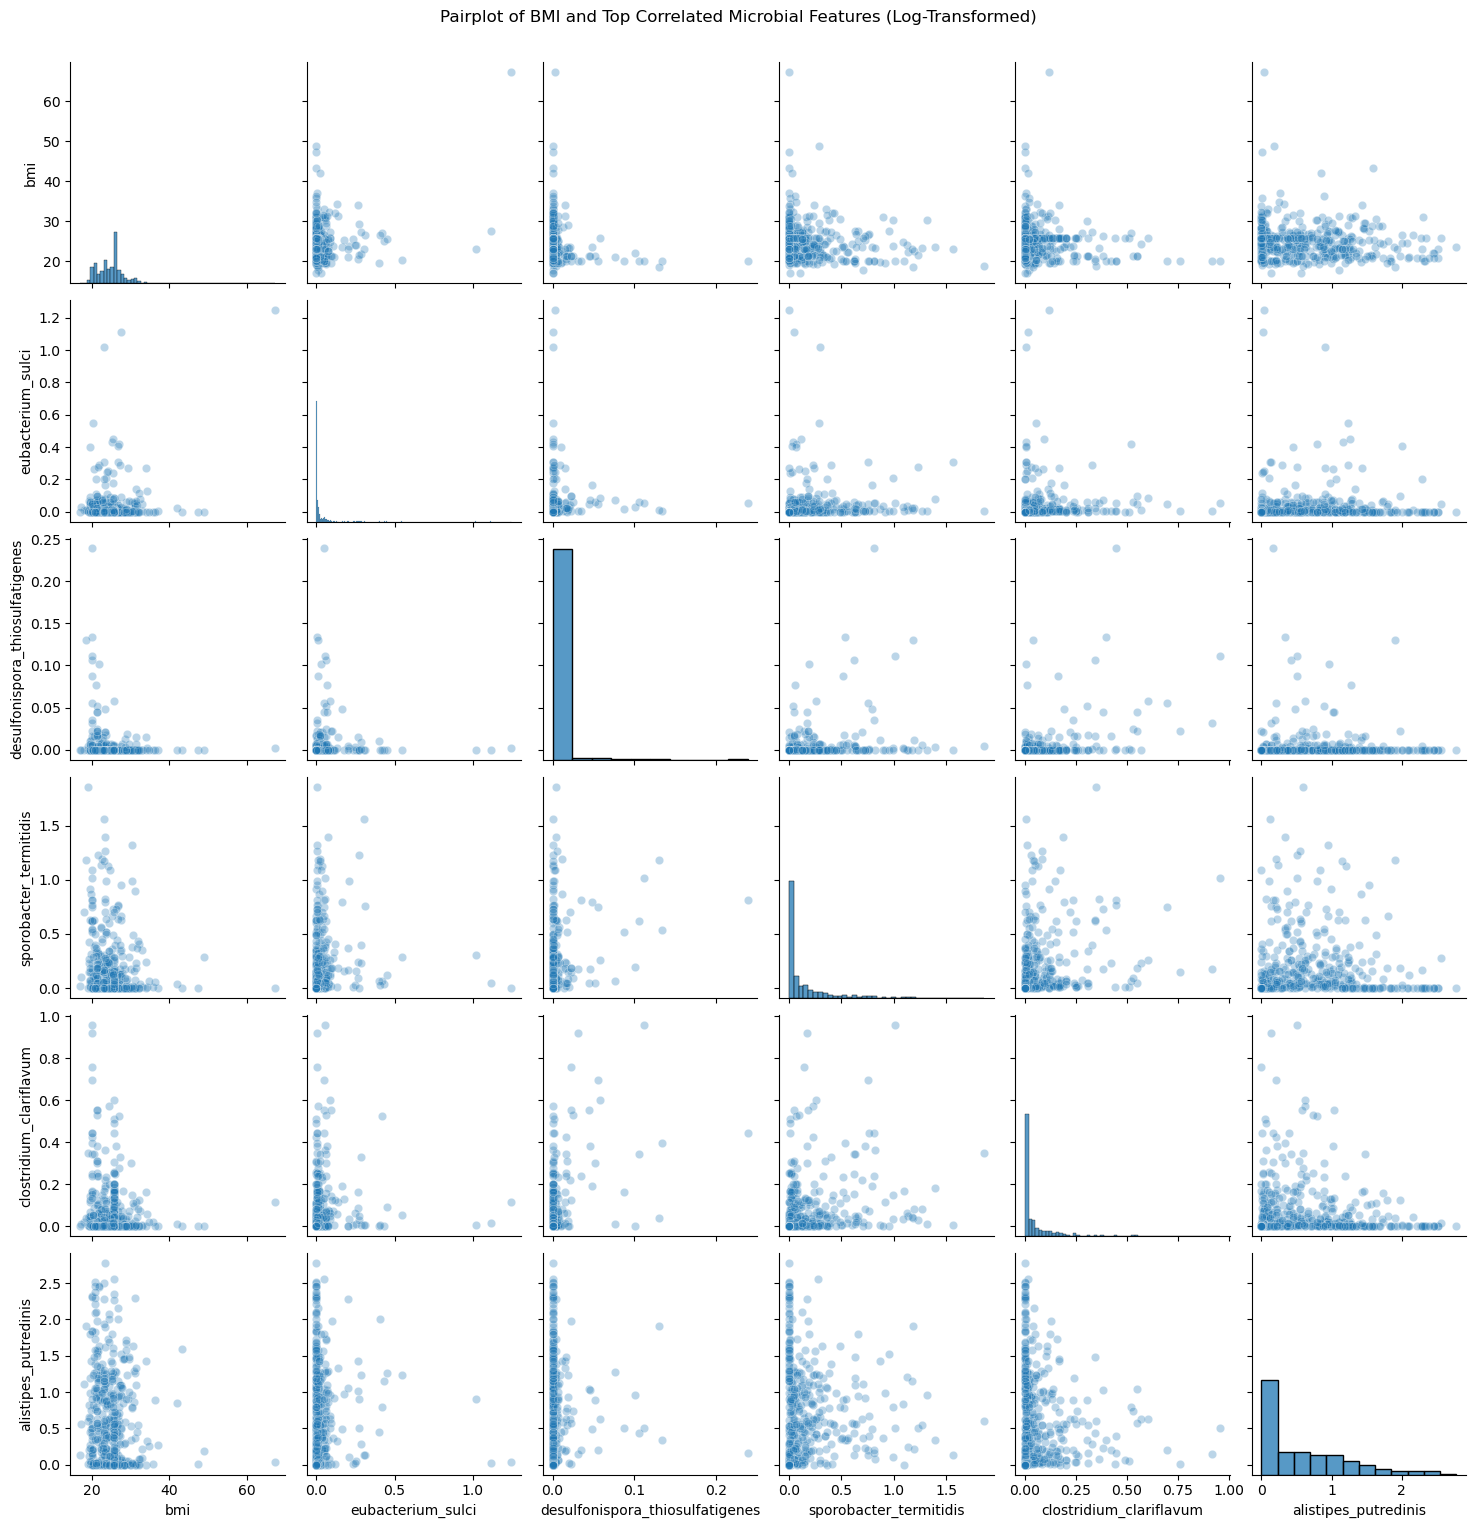

In [12]:
# Apply log transformation for microbial features
df_pairplot_log = df.copy()
for feature in corr_microbial_features[:5]:  
    df_pairplot_log[feature] = np.log1p(df_pairplot_log[feature])

# Define selected features including BMI
pairplot_features = ["bmi"] + list(corr_microbial_features[:5]) 

# Create pairplot with log-transformed features
sns.pairplot(df_pairplot_log[pairplot_features], diag_kind="hist", plot_kws={'alpha': 0.3})

# Add title
plt.suptitle("Pairplot of BMI and Top Correlated Microbial Features (Log-Transformed)", y=1.02)

plt.show()


### Stacked Bar Plot of Microbial Abundance by BMI Category
**Purpose:**  
Show the relative composition of microbial features across different BMI categories.  
**Insight:**  
- By normalizing the abundance (so that each category sums to 100%), we can easily compare the proportion of each bacterium.
- This visualization reveals how microbial community structure shifts across BMI groups.


/tmp/ipykernel_241426/2147182046.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_stacked = df.groupby('bmi_category')[var_microbial_features].mean()


<Figure size 1000x600 with 0 Axes>

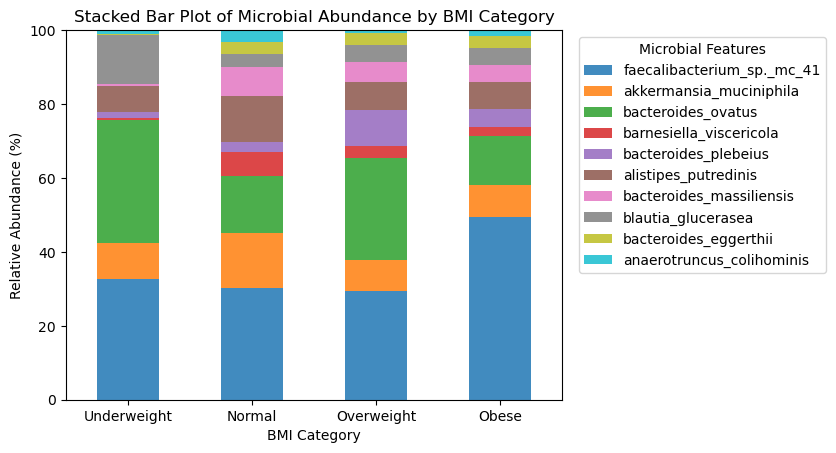

In [13]:
# Define BMI categories
bins = [0, 18.5, 24.9, 29.9, np.inf]
labels = ['Underweight', 'Normal', 'Overweight', 'Obese']
df['bmi_category'] = pd.cut(df['bmi'], bins=bins, labels=labels)

# Select top 10 microbial features based on variance
var_microbial_features = df[microbial_features].var().nlargest(10).index  

# Compute mean relative abundance for each BMI category
df_stacked = df.groupby('bmi_category')[var_microbial_features].mean()

# Normalize to get relative abundance (convert to %)
df_stacked = df_stacked.div(df_stacked.sum(axis=1), axis=0) * 100  

# Plot stacked bar chart
plt.figure(figsize=(10, 6))
df_stacked.plot(kind='bar', stacked=True, colormap="tab10", alpha=0.85)

# Formatting
plt.xlabel("BMI Category")
plt.ylabel("Relative Abundance (%)")  # Updated to reflect % values
plt.title("Stacked Bar Plot of Microbial Abundance by BMI Category")

# Updated legend placement
plt.legend(title="Microbial Features", bbox_to_anchor=(1.02, 1), loc="upper left", frameon=True, fontsize=10)

plt.xticks(rotation=0)  # Keep category labels horizontal for clarity
plt.ylim(0, 100)  # Set y-axis from 0 to 100%

plt.show()


### Boxplots of Microbial Features Across BMI Categories (Log-Transformed)
**Purpose:**  
Compare the distribution of key microbial features across BMI categories using boxplots and overlaid strip plots.  
**Insight:**  
- This helps in understanding the variability and potential outliers within each BMI group.
- Log scaling ensures that differences in low-abundance features are visible.


/root/miniconda3/envs/ml_env/lib/python3.9/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/root/miniconda3/envs/ml_env/lib/python3.9/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/root/miniconda3/envs/ml_env/lib/python3.9/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/root/miniconda3/envs/ml_env/lib/python3.9/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Pass

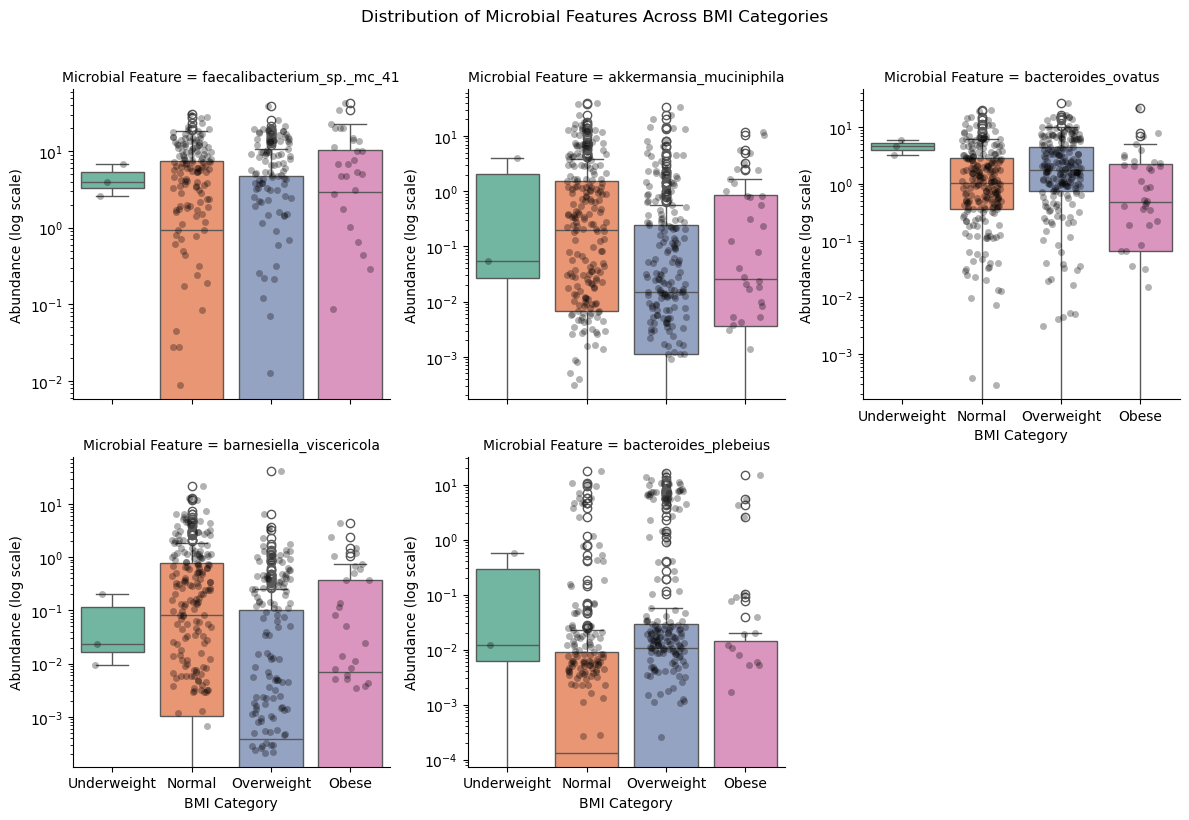

In [14]:
# Select the top 5 most variable microbial features for clarity
boxplot_features = var_microbial_features[:5]  # First 5 elements from var_microbial_features

# Reshape data for seaborn
df_melted_boxplot = df.melt(id_vars=['bmi_category'], value_vars=boxplot_features, 
                            var_name='Microbial Feature', value_name='Abundance')

# Initialize the FacetGrid
g_boxplot = sns.FacetGrid(df_melted_boxplot, col='Microbial Feature', col_wrap=3, sharey=False, height=4)

# Add boxplots
g_boxplot.map_dataframe(sns.boxplot, x='bmi_category', y='Abundance', palette='Set2')

# Add jittered stripplots for outliers
g_boxplot.map_dataframe(sns.stripplot, x='bmi_category', y='Abundance', 
                        color='black', alpha=0.3, jitter=0.25)  # Adjusted for better clarity

# Formatting
for ax in g_boxplot.axes.flatten():
    ax.set_yscale('log')  # Log scale for better visualization
    ax.set_xlabel("BMI Category")
    ax.set_ylabel("Abundance (log scale)")

plt.suptitle("Distribution of Microbial Features Across BMI Categories", y=1.02)
plt.tight_layout()  # Ensures no overlapping labels
plt.show()


### KDE Plots of Microbial Features Across BMI Categories
**Purpose:**  
Examine the smoothed density distributions of microbial features for different BMI categories.  
**Insight:**  
- KDE plots provide a clear view of the distribution shape and overlap between BMI groups.
- They help us identify features with highly overlapping distributions or distinct peaks, which is useful for feature selection.


/tmp/ipykernel_241426/4184963970.py:13: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=df, x=np.log1p(df[feature]), hue="bmi_category", fill=True, alpha=0.4, palette="tab10")


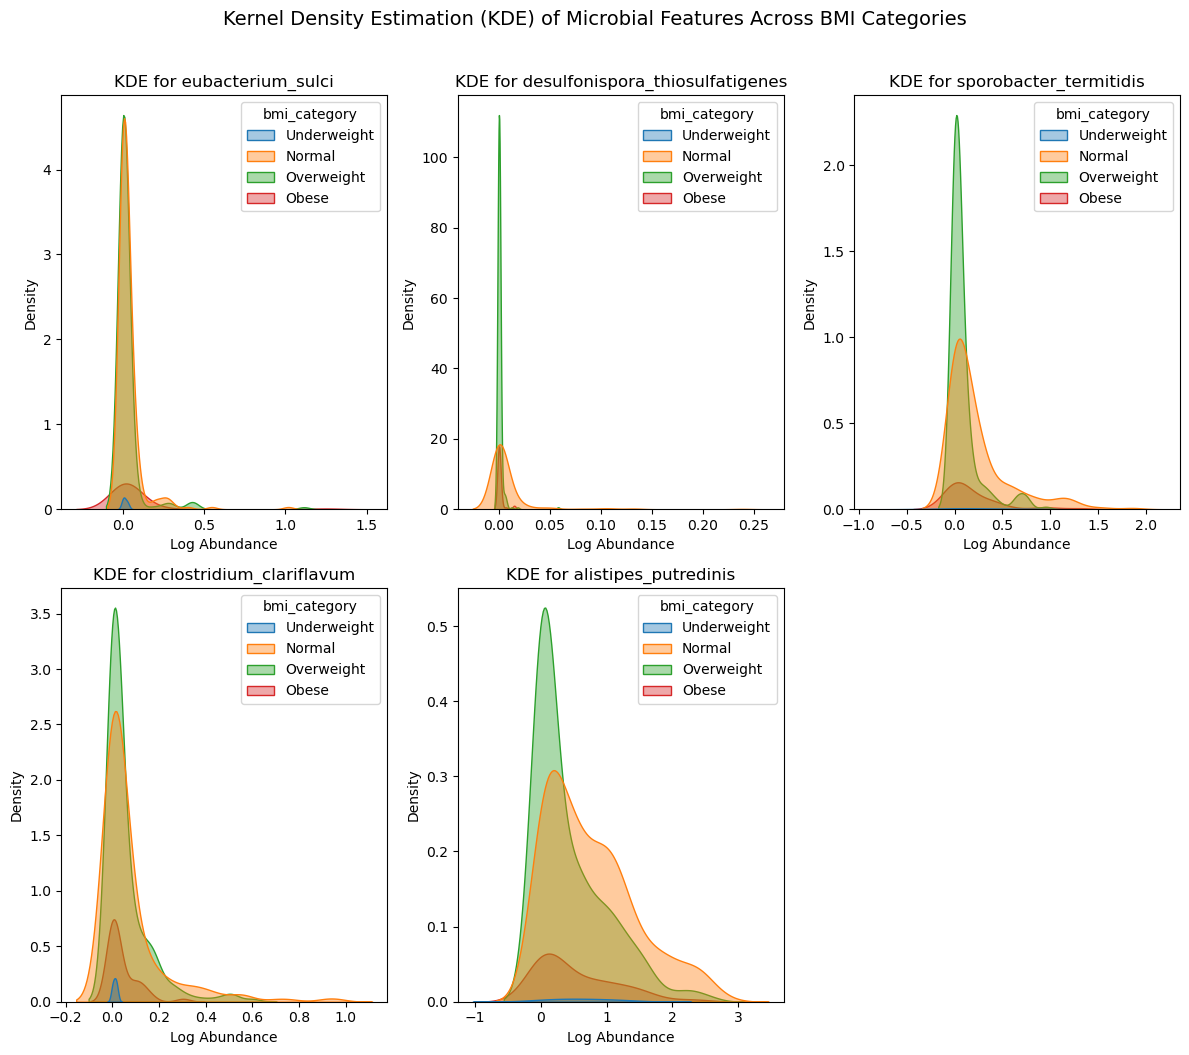

In [15]:
# Select the top 5 most correlated microbial features with BMI
kde_features = corr_microbial_features[:5]

# Plot size
plt.figure(figsize=(12, 10))

# Define the color palette for BMI categories
bmi_colors = sns.color_palette("tab10", n_colors=4)  # Using "tab10" for better differentiation

# Loop through each microbial feature and create individual KDE plots
for i, feature in enumerate(kde_features):
    plt.subplot(2, 3, i+1)  # 2 rows, 3 columns of subplots
    sns.kdeplot(data=df, x=np.log1p(df[feature]), hue="bmi_category", fill=True, alpha=0.4, palette="tab10")
    
    # Add plot labels and title
    plt.title(f"KDE for {feature}")
    plt.xlabel("Log Abundance")
    plt.ylabel("Density")

# Adjust layout for subplots
plt.tight_layout()

# Add a main title for the figure
plt.suptitle("Kernel Density Estimation (KDE) of Microbial Features Across BMI Categories", fontsize=14, y=1.05)

# Show the plots
plt.show()


### Z-Score Outlier Detection for Key Microbial Features
**Purpose:**  
Highlight the microbial features that have the most extreme values (outliers), as identified by Z-scores (|Z| > 3).  
**Insight:**  
- This visualization guides decisions on whether to transform, clip, or exclude features that are dominated by extreme values.
- It informs our choice of scaling (e.g., using RobustScaler to mitigate the effect of outliers).


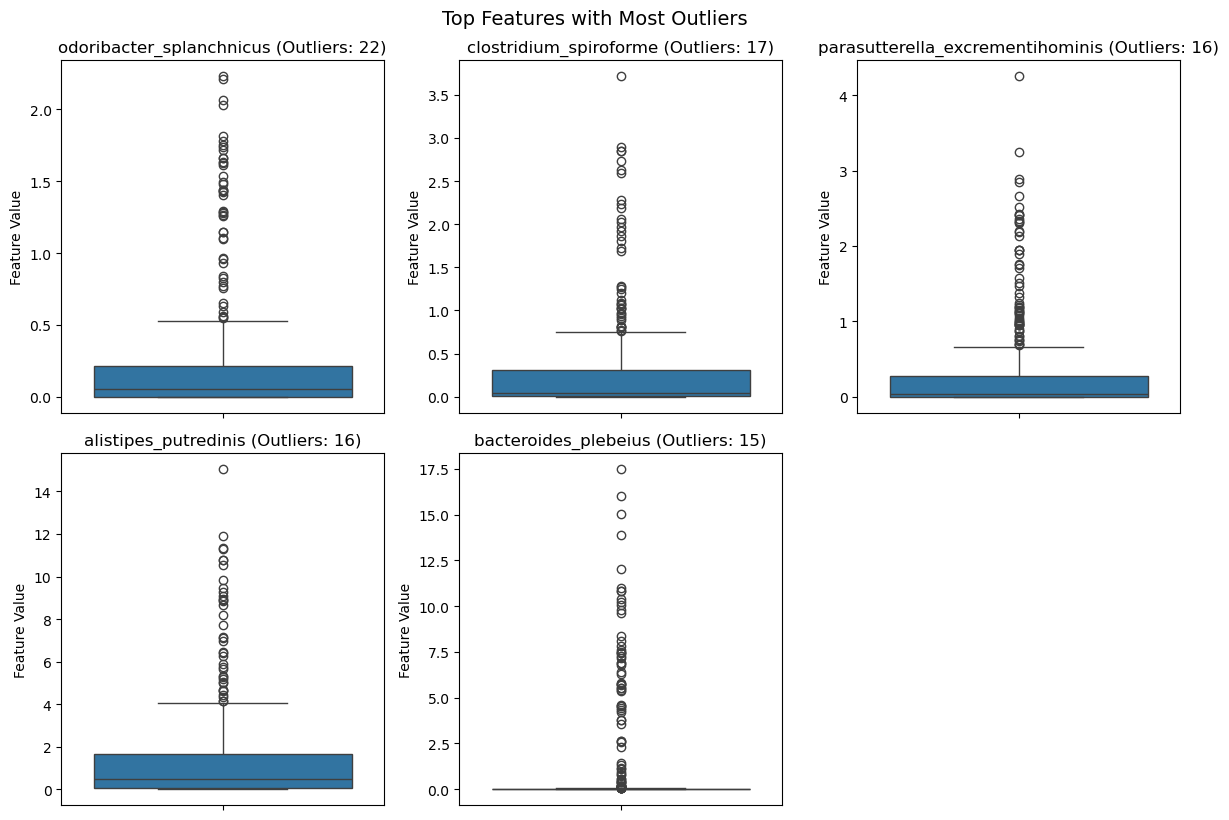

In [16]:
# Select features with the most outliers
top_outlier_features = outlier_counts.sort_values(ascending=False).head(5).index

# Create figure
plt.figure(figsize=(12, 8))

# Loop through features and plot boxplots
for i, feature in enumerate(top_outlier_features):
    plt.subplot(2, 3, i + 1)  # Create subplots (2 rows, 3 cols)
    
    # Boxplot for feature
    sns.boxplot(y=dev_df_clean[feature], showfliers=True)
    
    # Labeling
    plt.title(f"{feature} (Outliers: {outlier_counts[feature]})")
    plt.ylabel("Feature Value")

# Adjust layout
plt.tight_layout()
plt.suptitle("Top Features with Most Outliers", fontsize=14, y=1.02)

# Show plot
plt.show()


# 4️⃣ Feature Scaling & Saving Preprocessed Data
Before building our regression models, we scale the predictor features to reduce the impact of outliers and ensure consistency during cross-validation.  
- We use **RobustScaler** because it is less sensitive to extreme values.
- **Important:** We scale only the microbial (bacterial) features and other predictors, leaving the target variable (`bmi`) unscaled.
- Finally, we save the preprocessed development and validation datasets, along with the scaler and feature names, to ensure reproducibility and to apply the same transformations to unseen data.


## **Feature Scaling with `RobustScaler`**
### **Why Scaling is Needed**
- The features in our dataset have different scales:
  - **BMI values** range from ~17 to 67.
  - **Microbial abundance values** range from very small (e.g., `0.0001`) to much larger (e.g., `7.66`).
- If left unscaled, features with **larger magnitudes** might dominate the training process, leading to poor model performance.

### **Why `RobustScaler` Instead of `StandardScaler` or `MinMaxScaler`?**
- **StandardScaler** (Z-score normalization) assumes the data is normally distributed and uses **mean & standard deviation**, which are sensitive to outliers.
- **MinMaxScaler** scales data to a fixed range (**0 to 1**), but extreme values can heavily distort the transformation.
- **RobustScaler is better suited for our dataset because**:
  ✅ It uses the **median** and **interquartile range (IQR)** instead of mean/std, making it **resistant to outliers**.  
  ✅ It ensures that extreme microbial abundance values **do not distort the scale of other features**.  
  ✅ It preserves **relative feature importance** without being affected by rare, extremely large values.

Since our dataset contains **many extreme values (outliers)**, `RobustScaler` is the best choice to **normalize features while reducing the impact of outliers**.


### Applying RobustScaler and Saving Preprocessed Data
- Scale only the microbial features (bacterial species) using RobustScaler.
- Save the scaled datasets as “development_final_data.csv” and “evaluation_final_data.csv” per the assignment instructions.
- Also, save the scaler and the list of microbial features to ensure the same transformation can be applied to new data during model inference.


In [ ]:
# Create a copy for modeling purposes
df_model = dev_df_clean.copy()
df_val_model = val_df_clean.copy()

# Define features to scale: only the microbial features (bacterial species)
# Since our baseline model uses only bacterial features, we exclude non-bacterial predictors
features_to_scale = microbial_features

# Initialize the RobustScaler (which is robust to outliers)
scaler = RobustScaler()

# Fit the scaler on the development set and transform the selected features
df_model[features_to_scale] = scaler.fit_transform(df_model[features_to_scale])

# Apply the same transformation to the validation set
df_val_model[features_to_scale] = scaler.transform(df_val_model[features_to_scale])

# Save the preprocessed datasets using the assignment-specified filenames
df_model.to_csv("../data/development_final_data.csv", index=False)
df_val_model.to_csv("../data/evaluation_final_data.csv", index=False)

# Save the scaler for future use on unseen data
pickle.dump(scaler, open("../models/scaler.pkl", "wb"))

# Save feature names for future inference (ensuring correct feature order)
pickle.dump(microbial_features, open("../models/feature_names.pkl", "wb"))

print("✅ Feature scaling applied using RobustScaler, and preprocessed data & scaler saved!")
